Contenido bajo licencia Creative Commons BY 4.0 y código bajo licencia MIT. © Manuela Bastidas Olivares y Nicolás Guarín-Zapata 2024.

# Solucion de la ecuación de Poisson usando PINNs

## Descripción del problema

Queremos resolver la siguiente ecuación

\begin{align}
\nabla^2 u(x, y)  = f(x, y)\quad \forall (x, y) \in \Omega\\
u(x, y) = 0\quad \forall (x, y) \in \partial \Omega
\end{align}

En el ejemplo tendremos $\Omega = (0, 1)^2$.


## Aproximación de la función

En este caso tenemos una aproximación

$$u_\theta(x, y) \approx \operatorname{NN}(x, y; \theta)\, ,$$

done $\operatorname{NN}$ es una red neuronal con parámetros
entrenables $\theta$.

El residual para este problema estaría dado por

$$R(x) = \nabla^2 u_\theta(x, y)  - f(x, y) \, .$$

Por el caracter no linealidad respecto a los parámetros
$\theta$ de las redes neuronales evaluar el residual
en una serie de puntos $x_i$  y forzarlo a ser cero
en estos puntos, llevaría a un sistema
no lineal de ecuaciones

$$R(x_i, y_i) = 0 \quad \forall x_i\, .$$

## Función de pérdida

Una alternativa a resolver el sistema de ecuaciones anteriormente
planteado es minimizar

$$\min_\theta \frac{1}{N}\sum_{i}^N |R(x_i, y_i)|^2 \, .$$

Que sería exactamente 0 si cada uno de los residuales es igual a 0.

A este problema le harían falta las condiciones de frontera. Para
esto se propone una función objetivo que las incluya

$$\min_\theta \lambda_2\frac{1}{N}\sum_{i}^N R(x_i, y_i)^2 
+ \lambda_2 \frac{1}{M}\sum_{\substack{i\\ (x_i, y_i) \in \partial\Omega}}^M u_\theta(x_i, y_i)^2\, .$$

## Ejemplo computacional

In [1]:
# Esto permite tener gráficos interactivos en
# el caso de correrse en Google Colab
if 'google.colab' in str(get_ipython()):
    %pip install ipympl
    from google.colab import output
    output.enable_custom_widget_manager()

In [2]:
%matplotlib widget

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad

In [4]:
if 'google.colab' in str(get_ipython()):
    style = "https://raw.githubusercontent.com/nicoguaro/pinns_mapi-3/main/notebooks/clean.mplstyle"
else:
    style = "./clean.mplstyle"
plt.style.use(style)

In [5]:
class Model(torch.nn.Module):
    def __init__(self, neurons, n_layers, activation=torch.tanh):
        super(Model, self).__init__()
        self.activation = activation
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(2, neurons))
        for _ in range(n_layers-2):
            self.layers.append(torch.nn.Linear(neurons, neurons))
        self.layers.append(torch.nn.Linear(neurons, 1))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x


In [6]:
def f_rhs(x):
    return -4*torch.sin(2 * x)


def residual(u, x, f):
    u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    ddu = grad(du, x, grad_outputs=torch.ones_like(du), create_graph=True)[0]
    return ddu - f(x)


def loss_fn(u_model, x, f):
    u = u_model(x)
    res = residual(u, x, f)
    res_MSE = torch.mean(res**2)
    bc = u_model(torch.tensor([np.pi]))**2 + u_model(torch.tensor([0.]))**2
    return res_MSE + bc[0]


def train(model, optimizer, loss_fn, f, n_pts, iterations):
    losses = []
    for iteration in range(iterations):  
        optimizer.zero_grad()
        x = torch.FloatTensor(n_pts,1).uniform_(0, np.pi).requires_grad_(True)
        loss = loss_fn(model, x, f)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if iteration % 100 == 0:
            print(f'Iteration {iteration}, Loss {loss.item()}')
    return losses


def exact_u(x):
    return torch.sin(2 * x)

In [7]:
nn = 10
nl = 4
model = Model(neurons=nn, n_layers=nl)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Número de parámetros
sum(p.numel() for p in model.parameters() if p.requires_grad)

251

In [8]:
n_pts = 1000
iterations = 1000

In [9]:
losses = train(model, optimizer, loss_fn, f_rhs, n_pts, iterations)

Iteration 0, Loss 7.935050964355469
Iteration 100, Loss 5.811399936676025
Iteration 200, Loss 1.9693129062652588
Iteration 300, Loss 1.3940761089324951
Iteration 400, Loss 0.3754911422729492
Iteration 500, Loss 0.0246187262237072
Iteration 600, Loss 0.006336379796266556
Iteration 700, Loss 0.0026586230378597975
Iteration 800, Loss 0.0014682273613288999
Iteration 900, Loss 0.0009595984010957181


In [10]:
xlist = np.linspace(0, np.pi, n_pts)
xlist_torch = torch.tensor(xlist, dtype=torch.float32, requires_grad=True).view(-1, 1)

In [11]:
u_ap = model(xlist_torch)
u_ex = exact_u(xlist_torch)

Text(0, 0.5, 'u(x)')

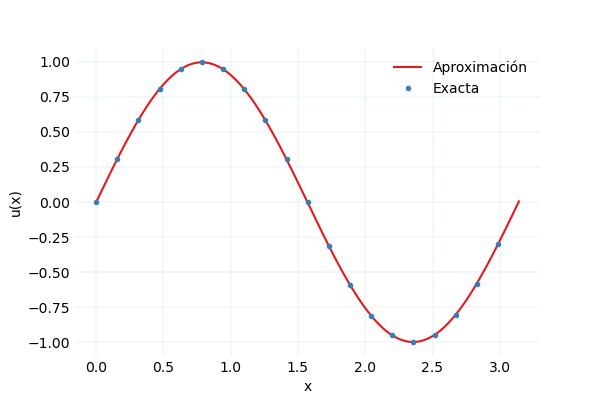

In [12]:
fig, ax = plt.subplots()
plt.plot(xlist, u_ap.detach().numpy())
plt.plot(xlist, u_ex.detach().numpy(), ".", markevery=50)
plt.legend(['Aproximación', 'Exacta'])
plt.xlabel("x")
plt.ylabel("u(x)")

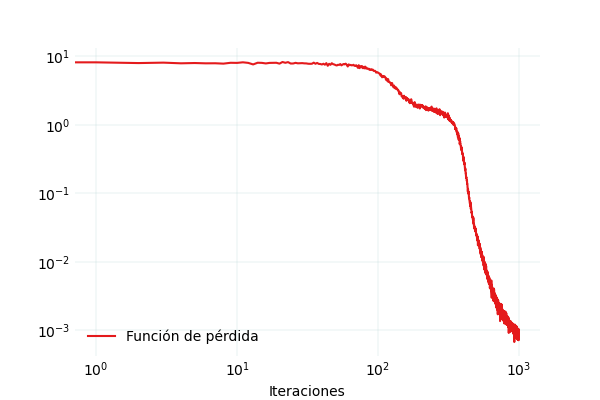

In [13]:
fig, ax = plt.subplots()
plt.loglog(losses)
plt.xlabel("Iteraciones")
plt.legend(['Función de pérdida'])

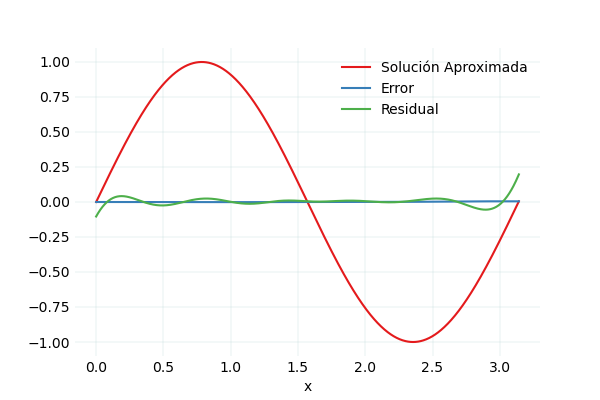

In [14]:
fig, ax = plt.subplots()
plt.plot(xlist, u_ap.detach().numpy())
plt.plot(xlist, (u_ap - u_ex).detach().numpy())
plt.plot(xlist, residual(u_ap, xlist_torch, f_rhs).detach().numpy())
plt.xlabel("x")
plt.legend(["Solución Aproximada", "Error", "Residual"])